In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import h5py

from pathlib import Path
from sglm.models import sglm_cv
import itertools
import time
import glob
import numpy as np
import pandas as pd
import numpy as np
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf
from sglm.features import setup_model_fit as smf
from sglm.models import sglm_cv
from sglm import models
from sglm.visualization import visualize
from sglm.models import train_model
from sglm.models import eval
from sglm import features
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import json

import traceback
import warnings
import sys

In [2]:
# From stack overflow
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [3]:
def extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_'):
    # needed info
    # Params: wt_used, signal_files, widest_orders, multifile_fit
    # Returns: mouse_names, combo_dfs, combo_fns, X_cols_sftd

    file_ids = [Path(_).parts[-1] for _ in signal_files]
    print('file_ids', file_ids)
    combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids, shift_spacer='_sft_', keep_unshifted=True)
#     combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep_nosft(signal_files, widest_orders, file_ids)
    combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
    mouse_names = combo_fns

    return mouse_names, combo_dfs, combo_fns, X_cols_sftd

In [4]:
def dump_dict_to_json(source_dict, json_path):
    with open(str((json_path).resolve()), 'w') as json_file:
        json.dump(source_dict, json_file)

def read_json(json_path):
    with open(str((json_path).resolve()), 'r') as json_file:
        read_json = json.load(json_file)
    return read_json

In [5]:
def id_rows_with_all_cols(dfrel_basis,
                          X_y_pairings,
                          X_cols_sftd, 
                          drop_cols_basis = ['nTrial', 'nTrial_filenum',
                                             'cpn', 'cpx', 'spnnr', 'spxnr', 'spnr', 'spxr',
                                             
                                             'photometryCenterInIndex', 'photometryCenterOutIndex',
                                             'photometrySideInIndexr', 'photometrySideInIndexnr',
                                             'photometrySideOutIndex', 'spnnrOff',
                                             
                                             'photometrySideInIndexAA', 'photometrySideInIndexAa',
                                             'photometrySideInIndexaA', 'photometrySideInIndexaa',
                                             'photometrySideInIndexAB', 'photometrySideInIndexAb',
                                             'photometrySideInIndexaB', 'photometrySideInIndexab',
#                                              'sl',
#                                              'slOff'
                                            ]):
    full_drop_basis = []
    y_col_lst = []
    for X_y_dct in X_y_pairings:
        full_drop_basis += bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd)
        y_col_lst += [X_y_dct['y_col']]
    y_col_drop_basis = sorted(list(set(y_col_lst)))
    full_drop_basis = sorted(list(set(drop_cols_basis + full_drop_basis + y_col_drop_basis)))

    num_cols_na = (dfrel_basis[full_drop_basis].isna().sum(axis=1))
    num_y_0 = (dfrel_basis[y_col_drop_basis] == 0).sum(axis=1)
    has_all_cols = (num_cols_na == 0)&(num_y_0 == 0)

    return has_all_cols

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [6]:
def get_holdout_and_cv_idx(df_available, pholdout, folds, pgss, filter_series, id_cols=['nTrial_filenum']):
    holdout_series = models.split_data.holdout_split_by_trial_id(df_available,
                                                                id_cols=id_cols,
                                                                perc_holdout=pholdout)
    cv_idx_lst = models.split_data.cv_idx_by_trial_id(dfrel_basis_has_all_cols[(~holdout_series)&(filter_series)],
                                                             trial_id_columns=id_cols,
                                                             num_folds=folds,
                                                             test_size=pgss)
    return holdout_series, cv_idx_lst

In [7]:
### Part 1
param_set_json_name = 'full_model_param_set.json'

# source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/interim')
# output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_clean')

# source_data_path = Path(r'/Users/josh/Documents/github_reposs/sabatinilab-glm/sglm/data/interim')
# output_path = Path(r'/Users/josh/Documents/github_reposs/sabatinilab-glm/sglm/outputs_check')

# source_data_path = Path(r'/Users/josh/Documents/github_reposs/sabatinilab-glm/sglm/data/mike-GLM_8020-interim')
# output_path = Path(r'/Users/josh/Documents/github_reposs/sabatinilab-glm/sglm/outputs-mike-GLM_8020')


# source_data_path = Path(r'/Users/josh/Documents/github_reposs/sabatinilab-glm/sglm/data/lynne-sanity-interim')
# output_path = Path(r'/Users/josh/Documents/github_reposs/sabatinilab-glm/sglm/outputs_lynne-sanity')


source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_7030-interim')
output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_7030')

# source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/mike-GLM_9010-interim')
# output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_9010')

preproc_params_name = r'preproc_params.json'
basis_name = r'_basis.csv'
# figname = 'fig_8020'
# figname = 'Figure_1'
# groupid = 'g1'
figname = 'fig'
groupid = 'g'
# param_set_id = '-20_+20_rwd'
# param_set_id = '-20_+20_rwd_wco_oldfilelist'
param_set_id = '-20_+20_rerunMac'


In [8]:
param_set_output_path = output_path / Path(figname) / Path(groupid) / Path(param_set_id)
param_set_dct = read_json(param_set_output_path / param_set_json_name)

source_data_path = Path(param_set_dct['source_data_path'])
output_path = Path(param_set_dct['output_path'])
basis_name = param_set_dct['basis_name']
figname = param_set_dct['figname']
groupid = param_set_dct['groupid']
param_set_id = param_set_dct['param_set_id']
neg_order = param_set_dct['neg_order']
pos_order = param_set_dct['pos_order']
fix_training = param_set_dct['fix_training']
num_runs = param_set_dct['num_runs']
folds = param_set_dct['folds']
pholdout = param_set_dct['pholdout']
pgss = param_set_dct['pgss']
score_method = param_set_dct['score_method']
val_test_inx_sel_method = param_set_dct['val_test_inx_sel_method']
X_y_pairings_lst = param_set_dct['X_y_pairings_lst']
kwargs_iterations = param_set_dct['kwargs_iterations']
kwargs_fixed = param_set_dct['kwargs_fixed']
dfrr_cols = param_set_dct['dfrr_cols']
count_event_names = param_set_dct['count_event_names']

glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

In [9]:
### Part 1
data_path = (source_data_path / figname / groupid)

interim_preproc_errors_path = data_path / 'interim_preproc_errors.csv'
interim_preproc_errors_df = pd.read_csv(str(interim_preproc_errors_path.resolve()))
error_file_list = interim_preproc_errors_df['out_file_errors'].to_list()

preproc_params = read_json(source_data_path / preproc_params_name)
dump_dict_to_json(preproc_params, param_set_output_path / preproc_params_name)



basis = pd.read_csv(source_data_path / basis_name, index_col=0)
basis['mouseid'] = basis['mouseid'].astype(str)
relevant_basis = basis[(basis['figname'] == figname)&(basis['groupid'] == groupid)]
wt_used = basis['mouseid'].tolist()

In [10]:
# Load Signal Data
signal_files = []
mouse_names = []
for inx, basis_row in basis.iterrows():
    signal_file_out = basis_row['signal_file_out']
    
    if signal_file_out in error_file_list:
        print(f'Preprocessing error found for file: {signal_file_out}')
        continue
    
    signal_path = data_path / signal_file_out
    signal_files.append(str(signal_path.resolve()))
    mouse_names.append(basis_row['mouseid'])

Preprocessing error found for file: GLM_SIGNALS_INTERIM_sstflp17_01092020.txt


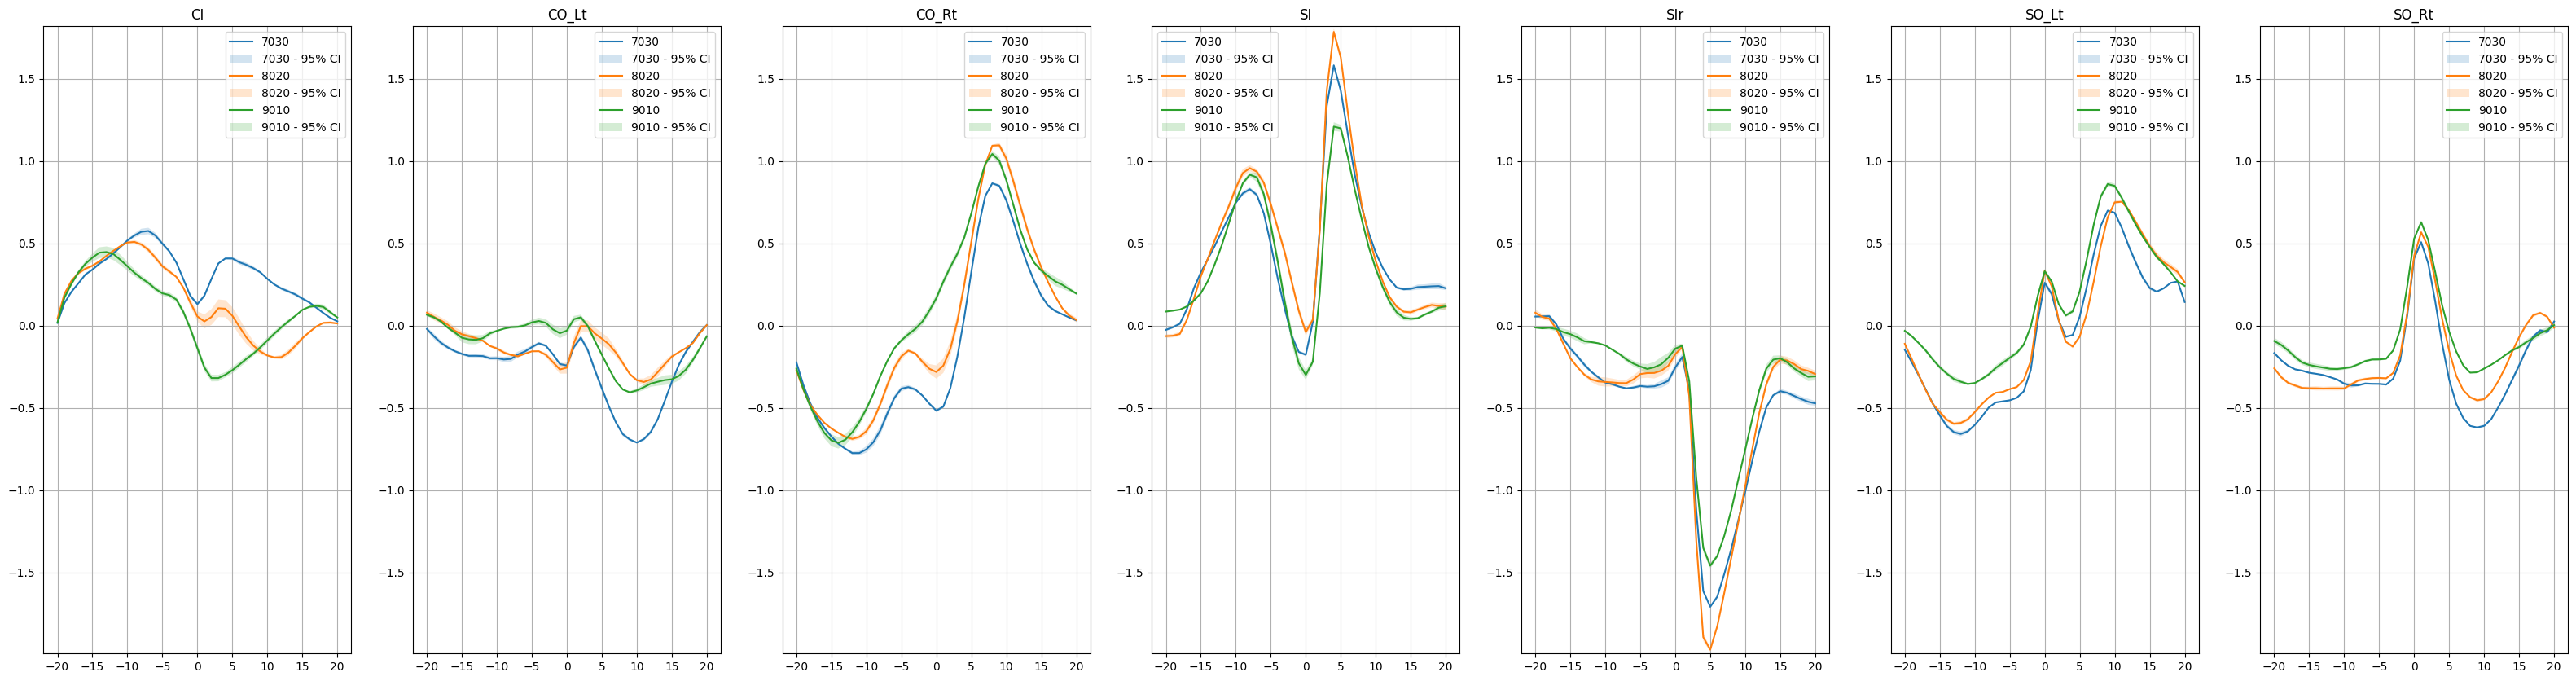

In [16]:
max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
#     for iXyd, X_y_dct in enumerate(X_y_pairings):
#         for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):




min_y = np.inf
max_y = -np.inf

all_agg_coefs_lst = []

for iXyd_p,Xyd_path in enumerate([
    Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_7030/fig/g/-20_+20_rerunMac-full/iXyp_0/iXyd_0-ikwargs_0/'),
    Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_8020/fig/g/-20_+20_rerunMac-full/iXyp_0/iXyd_0-ikwargs_0/'),
    Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_9010/fig/g/-20_+20_rerunMac-full/iXyp_0/iXyd_0-ikwargs_0/'),
]):
    agg_coefs_lst = []
    for irun in range(num_runs):
        run_start = time.time()

#         Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
#         Xyd_path = Xyp_path  / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}')
        run_path = Xyd_path / Path(f'irun_{irun}')
        fitted_glm = read_json(run_path / 'fitted_glm.json')

        coefs = pd.DataFrame(list(zip(fitted_glm['model']['X_names_'], fitted_glm['model']['coef_'])), columns=['name', 'coef'])
        coefs['name_lst'] = coefs['name'].str.split('_sft_')
        coefs['col'] = coefs['name_lst'].apply(lambda x: x[0])
        coefs['sft'] = coefs['name_lst'].apply(lambda x: x[1]).astype('int')
        
        coefs['reward_prob'] = Xyd_path.parts[7].split('GLM_')[-1]
        coefs['irun'] = irun
        
        agg_coefs_lst.append(coefs)

    agg_coefs = pd.concat(agg_coefs_lst)
    all_agg_coefs_lst.append(agg_coefs)

    gb_coefs = agg_coefs.groupby(['col', 'sft'])['coef'].agg([np.mean, np.std, np.size])
    gb_coefs['lb'] = gb_coefs['mean'] - gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
    gb_coefs['ub'] = gb_coefs['mean'] + gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
    
    npr = len(np.unique(np.stack(gb_coefs.index)[:,0]))
    
    gb_coefs = gb_coefs.reset_index()
    
    if iXyd_p == 0:
        fig,axes = plt.subplots(gb_coefs['col'].nunique()//npr,npr,figsize=(40,10))
        fig.set_facecolor('w')

    min_y = min(gb_coefs['lb'].min()-0.01, min_y)
    max_y = max(gb_coefs['ub'].max()+0.01, max_y)
    i = 0
    for gc, gc_df in gb_coefs.groupby('col'):
        axes[i%(npr)].set_title(gc.replace('Index','').replace('photometry','').replace('enter','').replace('ut','_').replace('ide','').replace('In','I'))
        axes[i%(npr)].plot(gc_df['sft'], gc_df['mean'], label=Xyd_path.parts[7].split('GLM_')[-1])
        axes[i%(npr)].fill_between(gc_df['sft'], gc_df['lb'], gc_df['ub'], alpha=0.2, label=Xyd_path.parts[7].split('GLM_')[-1] + ' - 95% CI')
        axes[i%(npr)].grid(True)
        axes[i%(npr)].legend()
        i += 1

    i = 0
    for gc, gc_df in gb_coefs.groupby('col'):
        axes[i%(npr)].set_ylim((min_y, max_y))
        i += 1

In [ ]:
gb_coefs

In [ ]:
pd.concat(all_agg_coefs_lst, axis=0).set_index(['col', 'sft', 'irun', 'reward_prob']).drop(['name', 'name_lst'], axis=1).unstack().unstack()
# pd.concat(all_agg_coefs_lst, axis=0).set_index(['col', 'sft', 'irun', 'reward_prob']).drop(['name', 'name_lst'], axis=1).unstack().unstack().to_csv(str(Path('/Users/josh/Desktop/mike-coefs.csv').resolve()))

In [ ]:

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
#     for iXyd, X_y_dct in enumerate(X_y_pairings):
#         for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
#             agg_coefs_lst = []
#             for irun in range(num_runs):
#                 run_start = time.time()
                
#                 Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
#                 run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
#                 fitted_glm = read_json(run_path / 'fitted_glm.json')
                
#                 coefs = pd.DataFrame(list(zip(fitted_glm['model']['X_names_'], fitted_glm['model']['coef_'])), columns=['name', 'coef'])
#                 coefs['name_lst'] = coefs['name'].str.split('_sft_')
#                 coefs['col'] = coefs['name_lst'].apply(lambda x: x[0])
#                 coefs['sft'] = coefs['name_lst'].apply(lambda x: x[1]).astype('int')
                
#                 agg_coefs_lst.append(coefs)
            
#             agg_coefs = pd.concat(agg_coefs_lst)

#             gb_coefs = agg_coefs.groupby(['col', 'sft'])['coef'].agg([np.mean, np.std, np.size])
#             gb_coefs['lb'] = gb_coefs['mean'] - gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
#             gb_coefs['ub'] = gb_coefs['mean'] + gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
            
#             npr = len(np.unique(np.stack(gb_coefs.index)[:,0]))
            
#             gb_coefs = gb_coefs.reset_index()
#             fig,axes = plt.subplots(gb_coefs['col'].nunique()//npr,npr,figsize=(20,5))
#             fig.set_facecolor('w')

#             min_y = gb_coefs['lb'].min()-0.01
#             max_y = gb_coefs['ub'].max()+0.01
#             i = 0
#             for gc, gc_df in gb_coefs.groupby('col'):
#                 axes[i%(npr)].set_title(gc.replace('Index','').replace('photometry','').replace('enter','').replace('ut','_').replace('ide','').replace('In','I'))
#                 axes[i%(npr)].plot(gc_df['sft'], gc_df['mean'])
#                 axes[i%(npr)].fill_between(gc_df['sft'], gc_df['lb'], gc_df['ub'], alpha=0.2)
#                 axes[i%(npr)].grid(True)
#                 i += 1

#             i = 0
#             for gc, gc_df in gb_coefs.groupby('col'):
#                 axes[i%(npr)].set_ylim((min_y, max_y))
#                 i += 1

In [ ]:
# break

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, _ in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            irun = 0
            
            run_start = time.time()
            Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
            run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
            preds_df = pd.read_csv(run_path / 'preds.csv', low_memory=False, index_col=0)
            preds_df = preds_df[preds_df['has_all_cols']].copy()
            
            preds_df['photometrySideInIndex'] = preds_df['photometrySideInIndexr'] + preds_df['photometrySideInIndexnr']
            
            alignment_cols = ['photometrySideOutIndexLt', 'photometrySideOutIndexRt',
                              
                              'photometrySideInIndexr', 'photometrySideInIndexnr',
                              'photometrySideInIndexAA', 'photometrySideInIndexAa',
                              'photometrySideInIndexAB', 'photometrySideInIndexAb',
                              'photometrySideInIndexaA', 'photometrySideInIndexaa',
                              'photometrySideInIndexaB', 'photometrySideInIndexab',
                             ]
            for alignment_col in alignment_cols:
                
                preds_df['ac_tmp'] = ((~preds_df['dupe'])*1.0)*((preds_df['diffTrialNums']==1.0)*1.0)*preds_df[alignment_col]
                preds_df['entryTime'] = preds_df.groupby(['nTrial_filenum'])['ac_tmp'].transform(np.argmax)

                preds_df['timestep'] = 1
                preds_df['timestep'] = preds_df.groupby(['nTrial_filenum'])['timestep'].cumsum() - 1
                preds_df['timestep'] = preds_df['timestep'] - preds_df['entryTime']
                
                preds_df[f'has_{alignment_col}'] = preds_df.groupby(['nTrial_filenum'])['ac_tmp'].transform(np.sum)
                preds_df[f'ts_{alignment_col}'] = preds_df['timestep']
            
            assert preds_df['holdout'].isna().sum() == 0
            preds_df['holdout'] = preds_df['holdout'].astype(bool)
            
            y_col = X_y_dct['y_col']
            preds_df['resids'] = preds_df[y_col] - preds_df['pred_'+y_col]
            preds_df['residsALL'] = preds_df[y_col] - preds_df['predALL_'+y_col]
            
            filt = (~preds_df['holdout'])&preds_df['wi_trial_keep']
            preds_df_train = preds_df[(~preds_df['holdout'])&preds_df['wi_trial_keep']]
            preds_df_holdout = preds_df[(preds_df['holdout'])&preds_df['wi_trial_keep']]
            
            print(time.time() - run_start)
            
            min_y = +np.inf
            max_y = -np.inf

            fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
            for iac, alignment_col in enumerate(alignment_cols):
                holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
                holdout_agg = holdout_agg.groupby([f'ts_{alignment_col}'])[[f'{y_col}', f'pred_{y_col}']].agg([np.mean, np.std, np.size]).dropna()                
                holdout_agg.columns = ['-'.join(_) for _ in holdout_agg.columns]

                holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg.index)['timestep'].between(-20,20)]                

                holdout_agg[f'{y_col}-lb'] = holdout_agg[f'{y_col}-mean'] - 1.96* holdout_agg[f'{y_col}-std']/np.sqrt(holdout_agg[f'{y_col}-size'])
                holdout_agg[f'{y_col}-ub'] = holdout_agg[f'{y_col}-mean'] + 1.96* holdout_agg[f'{y_col}-std']/np.sqrt(holdout_agg[f'{y_col}-size'])

                holdout_agg[f'pred_{y_col}-lb'] = holdout_agg[f'pred_{y_col}-mean'] - holdout_agg[f'pred_{y_col}-std']/np.sqrt(holdout_agg[f'pred_{y_col}-size'])
                holdout_agg[f'pred_{y_col}-ub'] = holdout_agg[f'pred_{y_col}-mean'] + holdout_agg[f'pred_{y_col}-std']/np.sqrt(holdout_agg[f'pred_{y_col}-size'])

                min_y = min(min_y, min(holdout_agg[f'{y_col}-lb'].min()-0.01, holdout_agg[f'pred_{y_col}-lb'].min()-0.01))
                max_y = max(max_y, max(holdout_agg[f'{y_col}-ub'].max()+0.01, holdout_agg[f'pred_{y_col}-ub'].max()+0.01))

                axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
                axes[iac//2,iac%2].plot(holdout_agg[f'{y_col}-mean'], label=f'True - {y_col} Mean')
                axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg[f'{y_col}-lb'], holdout_agg[f'{y_col}-ub'], alpha=0.2, label=f'True - {y_col} 95% CI')
                axes[iac//2,iac%2].plot(holdout_agg[f'pred_{y_col}-mean'], label='Pred - {y_col} Mean')
                axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg[f'pred_{y_col}-lb'], holdout_agg[f'pred_{y_col}-ub'], alpha=0.2, label=f'Pred - {y_col} 95% CI')
                axes[iac//2,iac%2].grid(True)
                axes[iac//2,iac%2].legend()


            i = 0
            for iac in enumerate(alignment_cols):
                axes[i//2,i%2].set_ylim((min_y, max_y))
                i += 1



In [ ]:
# tmp = (preds_df.groupby(['nTrial_filenum'])['ac_tmp'].sum())
# tmp[tmp > 1]


# with pd.option_context('display.max_rows',10000,'display.max_columns',10000):
#     display(preds_df[preds_df['nTrial_filenum'] == 1095].iloc[:, list(range(30))].replace(0,np.nan))#+list(range(-20,0))])

In [ ]:
def bootstrap_to_lower_upper_bounds(x, func, **kwargs):
    bs = scipy.stats.bootstrap((x,), func, **kwargs)
    return [bs.confidence_interval.low, bs.confidence_interval.high]

In [ ]:
import scipy
from tqdm.notebook import tqdm

seed = np.random.randint(1000000000)
boot_kwargs = dict(n_resamples=10,
               batch=None, vectorized=True, paired=False,
               axis=0, confidence_level=0.95, method='BCa',
               random_state=seed)

min_y = +np.inf
max_y = -np.inf

fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
for iac, alignment_col in tqdm(enumerate(alignment_cols), total=len(alignment_cols)):
    
    holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
    holdout_agg = holdout_agg.dropna()
    holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg[f'ts_{alignment_col}'])['timestep'].between(-20,20)]
#     display(holdout_agg)
    
    true_srs = holdout_agg.groupby(f'ts_{alignment_col}')[f'{y_col}'].apply(lambda x: np.array(x))
    pred_srs = holdout_agg.groupby(f'ts_{alignment_col}')[f'pred_{y_col}'].apply(lambda x: np.array(x))
    
    boot_df_setup = pd.DataFrame({
                            'true_mean':true_srs.apply(np.mean),
                            'pred_mean':pred_srs.apply(np.mean),

                            'true_lb_ub':true_srs.apply(lambda x: bootstrap_to_lower_upper_bounds(x, np.mean, **boot_kwargs)),
                            'pred_lb_ub':pred_srs.apply(lambda x: bootstrap_to_lower_upper_bounds(x, np.mean, **boot_kwargs)),
                           })
    
    
    boot_df_setup['true_lb'] = boot_df_setup['true_lb_ub'].apply(lambda x: x[0])
    boot_df_setup['true_ub'] = boot_df_setup['true_lb_ub'].apply(lambda x: x[1])
    boot_df_setup['pred_lb'] = boot_df_setup['pred_lb_ub'].apply(lambda x: x[0])
    boot_df_setup['pred_ub'] = boot_df_setup['pred_lb_ub'].apply(lambda x: x[1])

    boot_df = boot_df_setup[['true_lb', 'true_mean', 'true_ub',
             'pred_lb', 'pred_mean', 'pred_ub',]]
    
    
#     for sft in true_srs.index:
#         sft_data = true_srs.loc[sft]
#         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                                batch=None, vectorized=True, paired=False,
#                                axis=0, confidence_level=0.95, method='BCa',
#                                random_state=seed)
    

#         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

#         reconstruction_data_list.append(rtup)

#         tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
    
    
    min_y = min(min_y, min(boot_df['true_lb'].min()-0.01, boot_df['true_lb'].min()-0.01))
    max_y = max(max_y, max(boot_df['true_ub'].max()+0.01, boot_df['true_ub'].max()+0.01))

    axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
    axes[iac//2,iac%2].plot(boot_df['true_mean'], label=f'True - {y_col} Mean')
    axes[iac//2,iac%2].fill_between(boot_df.index, boot_df['true_lb'], boot_df['true_ub'], alpha=0.2, label=f'True - {y_col} 95% CI')
    axes[iac//2,iac%2].plot(boot_df['pred_mean'], label=f'Pred - {y_col} Mean')
    axes[iac//2,iac%2].fill_between(boot_df.index, boot_df['pred_lb'], boot_df['pred_ub'], alpha=0.2, label=f'Pred - {y_col} 95% CI')
    axes[iac//2,iac%2].grid(True)
    axes[iac//2,iac%2].legend()

i = 0
for iac in enumerate(alignment_cols):
    axes[i//2,i%2].set_ylim((min_y, max_y))
    i += 1

boot_df
    

In [ ]:
boot_df

In [ ]:


# min_y = +np.inf
# max_y = -np.inf

# fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
# for iac, alignment_col in enumerate(alignment_cols):
#     holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
#     holdout_agg = holdout_agg.groupby([f'ts_{alignment_col}'])[['true', 'pred']].agg([np.mean, np.std, np.size]).dropna()
#     holdout_agg.columns = ['-'.join(_) for _ in holdout_agg.columns]

#     holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg.index)['timestep'].between(-20,20)]                

#     min_y = min(min_y, min(holdout_agg['true_lb'].min()-0.01, holdout_agg['true_lb'].min()-0.01))
#     max_y = max(max_y, max(holdout_agg['true_ub'].max()+0.01, holdout_agg['true_ub'].max()+0.01))

#     axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
#     axes[iac//2,iac%2].plot(holdout_agg['true_mean'], label='True - GCAMP Mean')
#     axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['true_lb'], holdout_agg['true_ub'], alpha=0.2, label='True - GCAMP 95% CI')
#     axes[iac//2,iac%2].plot(holdout_agg['true_mean'], label='Pred - GCAMP Mean')
#     axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['true_lb'], holdout_agg['true_ub'], alpha=0.2, label='Pred - GCAMP 95% CI')
#     axes[iac//2,iac%2].grid(True)
#     axes[iac//2,iac%2].legend()




In [ ]:
# # stack all true values together--(along delta)
# # for delta long the rows... drop any nan values
# # bootstrap along the row


# seed = np.random.randint(1000000000)
# row = tmp_rdc.loc[delta].dropna().values
# bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                            batch=None, vectorized=True, paired=False,
#                            axis=0, confidence_level=0.95, method='BCa',
#                            random_state=seed)

# mn_val = row.mean()
# rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

# reconstruction_data_list.append(rtup)

# tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')


# seed = np.random.randint(1000000000)
# row = tmp_rdc.loc[delta].dropna().values
# bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                            batch=None, vectorized=True, paired=False,
#                            axis=0, confidence_level=0.95, method='BCa',
#                            random_state=seed)

# mn_val = row.mean()
# rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

# reconstruction_data_list.append(rtup)

# tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')


In [ ]:
# preds_df_holdout.groupby(['nTrial_filenum', 'timestep'])[['GCAMP', 'pred_GCAMP']].agg([np.mean, np.std])

In [ ]:



# [['GCAMP', 'pred_GCAMP']]